In [2]:
import numpy 
import pandas 

In [3]:
RAW_PATH = "../data/raw/"
TEMP_PATH = "../data/temp/"
DATA_PATH = "../data/train_test_split/"

RAW_FILE_NAME = "full_pull_v20000000000"

In [4]:
# import all 18 files from 00 to 17 and merge them into one file
data = pandas.DataFrame()

indexes = [str(i).zfill(2) for i in range(18)]

for index in indexes:
    file_name = RAW_PATH + RAW_FILE_NAME + index + ".csv"
    temp_data = pandas.read_csv(file_name)
    data = pandas.concat([data, temp_data])


In [5]:
# extract mbti
data['mbti'] = data['flair_text'].str.extract(r'([I|E][N|S][F|T][J|P])')

In [6]:
# remove flair_text and subreddit columns
data = data.drop(columns=['flair_text', 'subreddit'])
# remove rows without mbti 
data = data.dropna(subset=['mbti'])

In [7]:
# remove any markdown-style url from the body column but keep the text
data['body'] = data['body'].replace(r'\[(.*?)\]\(.*?\)', r'\1', regex=True)

In [8]:
# remove any url from the body column 
data['body'] = data['body'].replace(r'(http[s]?://|www\.)\S+', '', regex=True)

In [9]:
# remove any reddit like link from the body column like r/ or u/
data['body'] = data['body'].replace(r'[r|u]\/\S+', '', regex=True)

In [10]:
# remove any post with non-english characters
data = data[data['body'].str.contains(r'[^\x00-\x7F]+') == False]

In [11]:
data['body'] = data['body'].str.replace('&lt;', '<')
data['body'] = data['body'].str.replace('&gt;', '>')
data['body'] = data['body'].str.replace('&amp;', '&')
data['body'] = data['body'].str.replace('\n', ' ')

In [12]:
# group by author and check if they have more than one mbti 
author_mbti = data.groupby('author')['mbti'].nunique()
# remove authors with more than one mbti
author_mbti = author_mbti[author_mbti == 1]
data = data[data['author'].isin(author_mbti.index)]

In [13]:
# drop duplicates
data = data.drop_duplicates(subset=['author', 'body'])

In [14]:
# remove any post by Daenyx
data = data[data['author'] != 'Daenyx']

In [15]:
# add a column length for the length of the body
data['length'] = data['body'].str.len()

<Axes: ylabel='Frequency'>

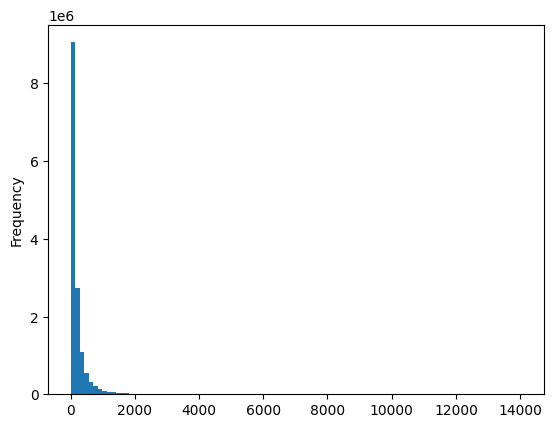

In [16]:
# plot the length distribution
data['length'].plot.hist(bins=100)

In [17]:
data.shape

(14496778, 4)

In [18]:
# remove post with more than 2000 characters. 
data = data[data['length'] <= 2000]
data.shape

(14407571, 4)

<Axes: ylabel='Frequency'>

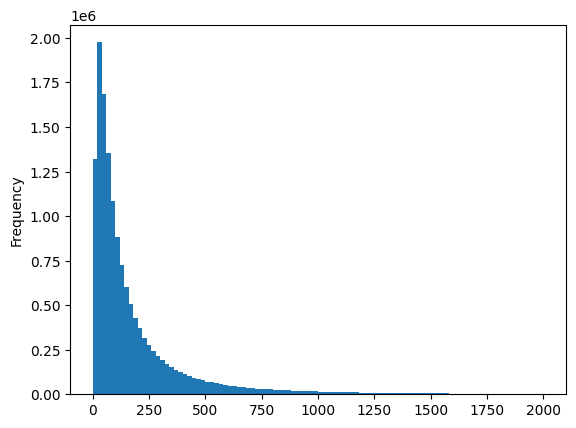

In [19]:
# plot the length distribution
data['length'].plot.hist(bins=100)

In [20]:
data.head()

,body,author,mbti,length
0,Lol that's why I left.,LadyBanterbury,INFP,23
1,"I was just about to post ""I try telling people...",Finarin,INTP,231
2,My first thought was Pepsi or something. Proba...,xanplease,INFP,62
3,"Not if the formula is something like ""every ti...",HeirToGallifrey,ENTP,103
5,"Well, I wouldn't know but I think there's a lo...",ElementalVoltage,INTP,324


In [21]:
import pandas as pd

def combine_short_texts(df, n):
    combined_data = []

    for author, group in df.groupby('author'):
        # Sort the group by length in ascending order
        group = group.sort_values(by='length')
        
        current_body = ""
        current_mbti = None
        for _, row in group.iterrows():
            if row['length'] >= n:
                # If the current text is already long enough, add the previous combined text if it exists
                if current_body:
                    combined_data.append({'author': author, 'body': current_body, 'mbti': current_mbti, 'length': len(current_body)})
                    current_body = ""
                # Add the long text directly to the combined data
                combined_data.append(row)
            else:
                if not current_body:
                    current_mbti = row['mbti']
                current_body += row['body'] + " "
                if len(current_body) >= n:
                    combined_data.append({'author': author, 'body': current_body.strip(), 'mbti': current_mbti, 'length': len(current_body)})
                    current_body = ""

        # Add any remaining combined text
        if current_body:
            combined_data.append({'author': author, 'body': current_body.strip(), 'mbti': current_mbti, 'length': len(current_body)})

    # Create a new DataFrame from the combined data
    combined_df = pd.DataFrame(combined_data)
    return combined_df




In [22]:
combined_data = combine_short_texts(data, 2500)

<Axes: ylabel='Frequency'>

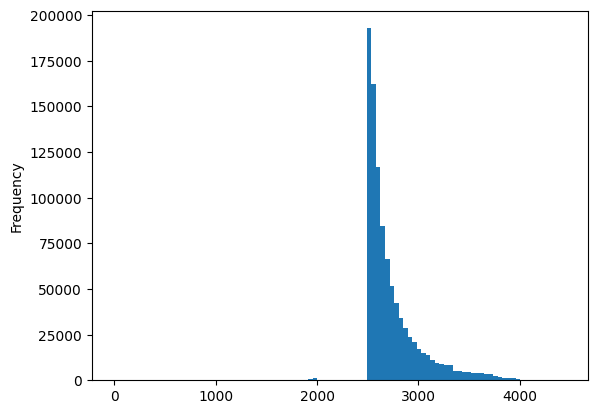

In [23]:
combined_data['length'] = combined_data['body'].str.len()
combined_data['length'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

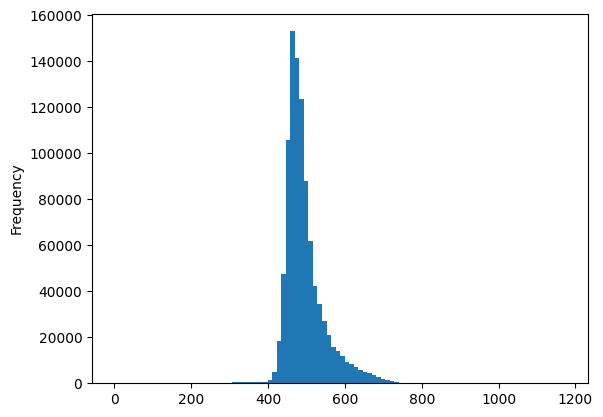

In [24]:
# split the body into words and count words 
combined_data['word_count'] = combined_data['body'].str.split().str.len()
combined_data['word_count'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

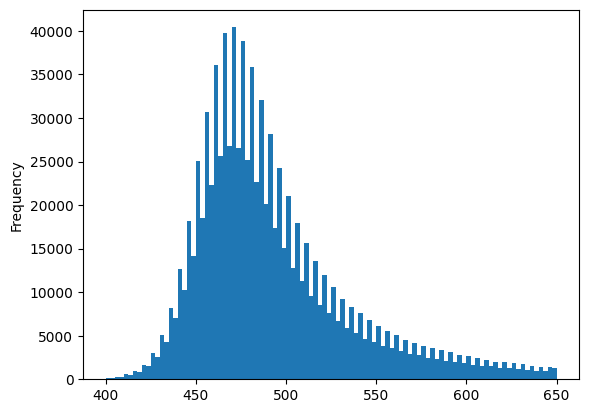

In [25]:
# remove rows with word count less than 400 and more than 650 
combined_data = combined_data[(combined_data['word_count'] >= 400) & (combined_data['word_count'] <= 650)]
combined_data['word_count'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

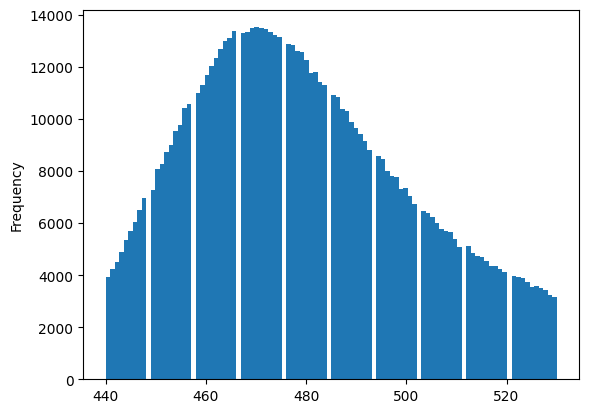

In [26]:
# remove rows with word count less than 440 and more than 530 
combined_data = combined_data[(combined_data['word_count'] >= 440) & (combined_data['word_count'] <= 530)]
combined_data['word_count'].plot.hist(bins=100)

In [27]:
combined_data = combined_data.drop(columns=['length', 'word_count'])
# split mbti into 4 columns
combined_data['E-I'] = combined_data['mbti'].str[0]
combined_data['N-S'] = combined_data['mbti'].str[1]
combined_data['F-T'] = combined_data['mbti'].str[2]
combined_data['J-P'] = combined_data['mbti'].str[3]

In [28]:
# shuffle the data 
combined_data = combined_data.sample(frac=1, random_state=42)

In [33]:
# print the percentage of each mbti type
print(combined_data['E-I'].value_counts(normalize=True))
print(combined_data['N-S'].value_counts(normalize=True))
print(combined_data['F-T'].value_counts(normalize=True))
print(combined_data['J-P'].value_counts(normalize=True))

E-I
I    0.787041
E    0.212959
Name: proportion, dtype: float64
N-S
N    0.924984
S    0.075016
Name: proportion, dtype: float64
F-T
T    0.539207
F    0.460793
Name: proportion, dtype: float64
J-P
P    0.599108
J    0.400892
Name: proportion, dtype: float64


In [34]:
# Proportions for each MBTI dimension
proportions = {
    'mbti_0': {'E': 0.212959, 'I': 0.787041},
    'mbti_1': {'N': 0.924984, 'S': 0.075016},
    'mbti_2': {'F': 0.460793, 'T': 0.539207},
    'mbti_3': {'J': 0.400892, 'P': 0.599108}
}

# Function to calculate baseline F1 score
def calculate_baseline_f1(proportions):
    f1_scores = {}
    for dim, prop in proportions.items():
        r = max(prop.values())
        f1_scores[dim] = 2 * r / (1 + r)
    return f1_scores

# Calculate baseline F1 scores
baseline_f1_scores = calculate_baseline_f1(proportions)
for dim, score in baseline_f1_scores.items():
    print(f"Baseline F1 score for {dim}: {score}")

Baseline F1 score for mbti_0: 0.8808314974306689
Baseline F1 score for mbti_1: 0.9610303254468608
Baseline F1 score for mbti_2: 0.700629609922512
Baseline F1 score for mbti_3: 0.7493027362754735


In [29]:
# import train_test_split
from sklearn.model_selection import train_test_split

# split the data into train and test
train_data, test_data = train_test_split(combined_data, test_size=0.2, random_state=42, stratify=combined_data['mbti'])

In [30]:
# save the data into DATA_PATH
train_data.to_csv(DATA_PATH + "train.csv", index=False)
test_data.to_csv(DATA_PATH + "test.csv", index=False)